In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

audioFilePaths = []
recordingInfoFilePaths = []
for dirname, _, filenames in os.walk('./Respiratory_Sound_Database/audio_and_txt_files'):
    for filename in filenames:
        fullPath = os.path.join(dirname, filename)
        if filename.endswith("wav"):
            audioFilePaths.append(fullPath)
        elif filename.endswith("txt"):
            recordingInfoFilePaths.append(fullPath) 
        #print(os.path.join(dirname, filename))

print(len(audioFilePaths))
print(len(recordingInfoFilePaths))

920
920


In [2]:
import csv

def extractFilenameWithoutExtension(fullPath):
    fileName = os.path.basename(fullPath)
    fileNameWithoutPath = os.path.splitext(fileName)[0]
    return fileNameWithoutPath

#(fullPaths:string[]) => dict<filename:string, (start, end, hasCrackles, hasWheezes)[]>
def getFileInfoDict(pathList):
    fileInfoDict = {}
    for path in pathList:
        fileNameWithoutPath = extractFilenameWithoutExtension(path) 
        infoList = []
        with open(path, 'r') as hFile:
            reader = csv.reader(hFile, delimiter='\t')
            for row in reader:
                startTime = float(row[0])
                endTime = float(row[1])
                hasCrackles = True if int(row[2]) == 1 else False
                hasWheezes = True if int(row[3]) == 1 else False
                infoList.append((startTime, endTime, hasCrackles, hasWheezes))
                
        fileInfoDict[fileNameWithoutPath] = infoList
    return fileInfoDict
 
audioFilePathsWithoutExtension = [extractFilenameWithoutExtension(path) for path in audioFilePaths]
fileInfoDict = getFileInfoDict(recordingInfoFilePaths)
#List order is aligned with the order in which the audio clips are extracted
fileInfoList = [fileInfoDict[audioPath] for audioPath in audioFilePathsWithoutExtension] 


In [6]:
def getFilenameInfo(file):
    return file.split('_')

In [7]:
audioFilePathsWithoutExtension[0]

'200_2p4_Al_mc_AKGC417L'

In [8]:
import librosa
from tqdm import tqdm

gSampleRate = 7000

basePath = './Respiratory_Sound_Database/audio_and_txt_files/'

def loadFiles(fileList):
    outputBuffers = []
    for filename in tqdm(fileList):
        name_data = getFilenameInfo(filename)
        filename = basePath + filename + '.wav'
        audioBuffer, nativeSampleRate = librosa.load(filename, dtype=np.float32, mono=True, sr=None)
        if nativeSampleRate == gSampleRate:
            outputBuffers.append((audioBuffer, name_data[0]))
        else:
        #Linear resampling using numpy is significantly faster than Librosa's default technique
            duration = len(audioBuffer) / nativeSampleRate
            nTargetSamples = int(duration * gSampleRate)
            timeXSource = np.linspace(0, duration, len(audioBuffer), dtype=np.float32)
            timeX = np.linspace(0, duration, nTargetSamples, dtype=np.float32)
            resampledBuffer = np.interp(timeX, timeXSource, audioBuffer)
            outputBuffers.append((resampledBuffer, name_data[0]))
            
    return outputBuffers

audioBuffers = loadFiles(audioFilePathsWithoutExtension)

100%|██████████| 920/920 [02:44<00:00,  5.58it/s]


In [9]:
from scipy import signal
import matplotlib.pyplot as plt

upperCutoffFreq = 3000
cutoffFrequencies = [80, upperCutoffFreq]

#FIR coefficients for a bandpass filter with a window of 80-3000 Hz
highPassCoeffs = signal.firwin(401, cutoffFrequencies, fs=gSampleRate, pass_zero="bandpass")

def applyHighpass(npArr):
    return signal.lfilter(highPassCoeffs, [1.0], npArr)

#Higher gamma results in more aggressive compression
def applyLogCompressor(signal, gamma):
    sign = np.sign(signal)
    absSignal = 1 + np.abs(signal) * gamma
    logged = np.log(absSignal)
    scaled = logged * (1 / np.log(1.0 + gamma)) #Divide by the maximum possible value from compression
    return sign * scaled

#Scales all samples to ensure the peak signal is 1/-1
def normalizeVolume(npArr):
    minAmp, maxAmp = (np.amin(npArr), np.amax(npArr))
    maxEnv = max(abs(minAmp), abs(maxAmp))
    scale = 1.0 / maxEnv
    #in place multiply
    npArr *= scale
    return npArr

#Removing the low-freq noise, re-normalizing volume then apply compressor
noiseRemoved=[]
for buffer in tqdm(audioBuffers):
    denoised = normalizeVolume(applyHighpass(buffer[0]))
    denoised = applyLogCompressor(denoised, 30)
    noiseRemoved.append((denoised, buffer[1]))
# noiseRemoved = [normalizeVolume(applyHighpass(buffer)) for buffer in audioBuffers]
# noiseRemoved = [applyLogCompressor(sig, 30) for sig in noiseRemoved]


100%|██████████| 920/920 [00:09<00:00, 99.61it/s] 


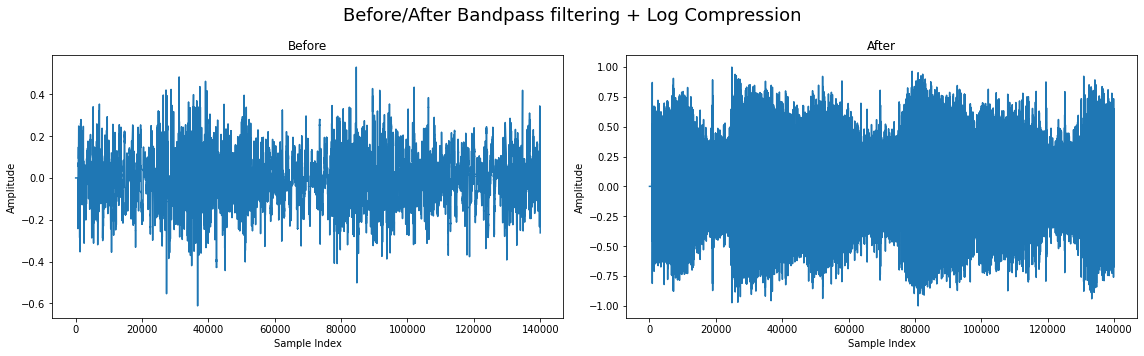

Before Filtering


Post Filtering


In [10]:
import IPython.display as ipd

fig, axs = plt.subplots(1,2, figsize=(16,5))

selectedSampleIdx = 17

fig.suptitle('Before/After Bandpass filtering + Log Compression', fontsize=18)

axs[0].plot(audioBuffers[selectedSampleIdx][0])
axs[0].set_title("Before")

axs[1].plot(noiseRemoved[selectedSampleIdx][0])
axs[1].set_title("After")

for ax in axs.flat:
    ax.set(ylabel='Amplitude', xlabel='Sample Index')    

plt.tight_layout() 
plt.show()

print("Before Filtering")
ipd.display(ipd.Audio(audioBuffers[selectedSampleIdx][0], rate=gSampleRate))
print("Post Filtering")
ipd.display(ipd.Audio(noiseRemoved[selectedSampleIdx][0], rate=gSampleRate))

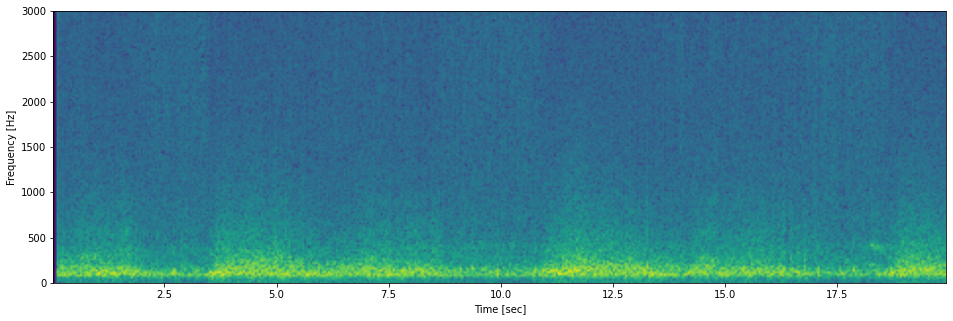

In [13]:
windowSizeSeconds = 0.05 
windowSampleSize = int(gSampleRate * windowSizeSeconds)

def plotSpectrogram(specData):
    plt.figure(figsize=(16,5))
    #Gamma scaling factor of 0.1 needed to make spectrogram more readable
    plt.pcolormesh(specData[1], specData[0], np.power(specData[2],0.1) , shading='gouraud')
    plt.ylim(0, upperCutoffFreq)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    
#(audioBuffers:float[][]) => (frequencies:float[], time(seconds):float[], amplitudes:float[][]))[]
def getSpectrograms(audioBuffers):
    spectrograms = []
    for buffer in audioBuffers:
        freqTable, times, powerSpectrum = signal.spectrogram(buffer[0], gSampleRate, nperseg=windowSampleSize)
        spectrograms.append(((freqTable, times, powerSpectrum),buffer[1]))
    return spectrograms

spectrograms = getSpectrograms(noiseRemoved)
plotSpectrogram(spectrograms[selectedSampleIdx][0])

3

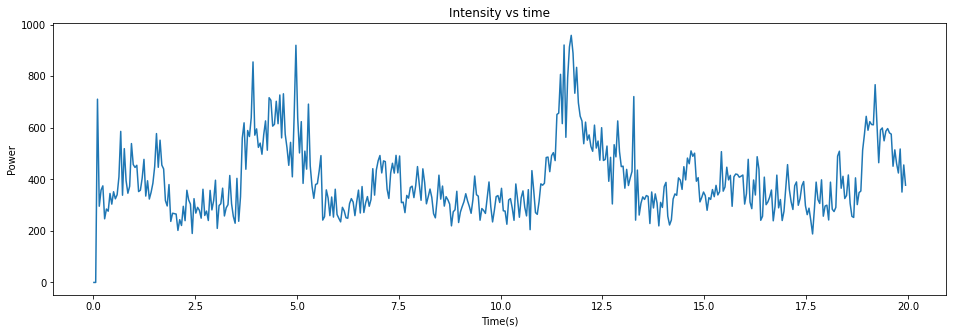

In [14]:
def getPowerEnvelop(spectrogram, cutoff, plot=False):
    frequencies = spectrogram[0]
    timeSlices = spectrogram[1]
    spectrum = spectrogram[2]
    
    maxInd = np.sum(frequencies <= cutoff)
    truncFreq = frequencies[:maxInd]
    
    powerEnvelop = []
    for idx, _ in enumerate(timeSlices):
        freqAmplitudes = spectrum[:maxInd,idx]
        
        powerBins = freqAmplitudes * np.square(truncFreq)
        powerEnvelop.append(sum(powerBins))
    if (plot): 
        plt.figure(figsize=(16,5))
        plt.title("Intensity vs time")
        plt.plot(timeSlices, powerEnvelop)
        plt.xlabel("Time(s)")
        plt.ylabel("Power")
        plt.show()
        
    return (timeSlices, powerEnvelop)

time, amp = getPowerEnvelop(spectrograms[selectedSampleIdx][0], upperCutoffFreq, True)

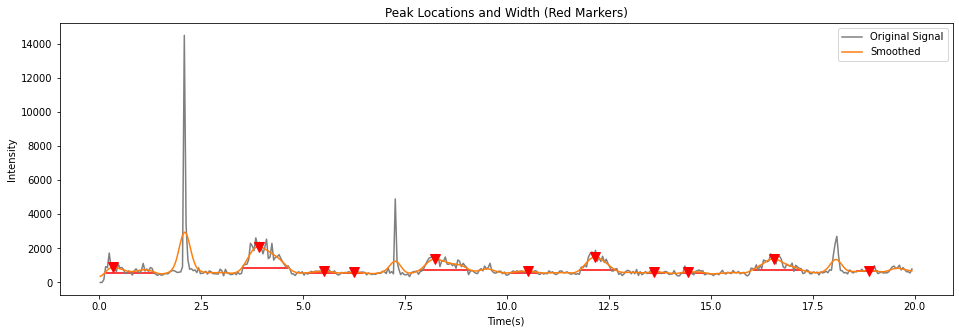

In [25]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.signal import peak_widths
import math

#(amplitudes:float[], time(seconds):float[], sampleInterval(seconds):float, minPeakDuration(seconds):float, gaussainSmoothingSigma:float, peakRelHeight(0-1):float, plot:bool) =>
#(smoothed:float[], peakTiming(seconds):float[], leftRightBoundaries:(left(seconds):float, right(seconds):float)[])
def findPeaksAndWidthsFromSmoothedCurve(amplitudes,time, sampleInterval, minPeakDuration=0.4, gaussianSmoothingSigma = 3, peakRelHeight=0.8, plot=False):
    smoothed = gaussian_filter1d(amplitudes, gaussianSmoothingSigma)
    minPeakDurationSamples = int(math.ceil(minPeakDuration / sampleInterval))
    peakIndices, _ = find_peaks(smoothed, width=minPeakDurationSamples) 
    peakWidthResult = peak_widths(smoothed, peakIndices, peakRelHeight)
    
    leftPeakTimes = time[np.rint(peakWidthResult[2]).astype(int)]
    rightPeakTimes = time[np.rint(peakWidthResult[3]).astype(int)]
    leftRightBoundaries = list(zip(leftPeakTimes, rightPeakTimes))
    
    peakTiming = time[peakIndices]
    if plot:
        plt.figure(figsize=(16,5))
        plt.plot(time, amplitudes, color="tab:gray", label="Original Signal") 
        plt.plot(time, smoothed, color="tab:orange", label="Smoothed")
        plt.plot(peakTiming, smoothed[peakIndices], "v", color="red", markersize=10)
        plt.hlines(peakWidthResult[1], leftPeakTimes , rightPeakTimes , color="red")
        plt.xlabel("Time(s)")
        plt.ylabel("Intensity")
        plt.title("Peak Locations and Width (Red Markers)")
        plt.legend()
        plt.show()
        
    return (smoothed, peakTiming, leftRightBoundaries)
    

_  = findPeaksAndWidthsFromSmoothedCurve(amp, time, windowSizeSeconds, plot=True)

In [26]:
spectrograms[5][1]

'147'

In [27]:
#Calulate power envelop from sepctrogram
#(time(s):float[], amp:float[])
powerEnvelops=[]
for spectrogram in tqdm(spectrograms):
    powerEnvelop = getPowerEnvelop(spectrogram[0], upperCutoffFreq, False)
    powerEnvelops.append((powerEnvelop, spectrogram[1]))
# powerEnvelops = [getPowerEnvelop(spectrogram, upperCutoffFreq, False) for spectrogram in spectrograms]

100%|██████████| 920/920 [00:13<00:00, 69.31it/s]


In [28]:
from sklearn.model_selection import train_test_split

trainIndices, testIndices = train_test_split(range(len(recordingInfoFilePaths)), test_size=0.2, random_state=0xDEADBEEF)

def multiIndexList(sourceList, indices):
    return [obj for idx, obj in enumerate(sourceList) if idx in indices]

trainFileNames = multiIndexList(audioFilePathsWithoutExtension, trainIndices)
testFileNames = multiIndexList(audioFilePathsWithoutExtension, testIndices)

In [29]:
#Peak identification from power envelop
#(smoothedSignal:float[], peakTiming:seconds[], peakLeftRightBoundaries:(left:float,right:float)[])[]
# peakData = [findPeaksAndWidthsFromSmoothedCurve(amp, time, windowSizeSeconds) for time, amp in powerEnvelops]
peakData=[]

for powerEnvelop in powerEnvelops:
    time, amp = powerEnvelop[0]
    peak = findPeaksAndWidthsFromSmoothedCurve(amp, time, windowSizeSeconds)
    peakData.append((peak, powerEnvelop[1]))

trainPeakData =  multiIndexList(peakData, trainIndices)
testPeakData =  multiIndexList(peakData, testIndices)

In [30]:
#Compare the difference between the middle of the detected cycle and the middle of the closest hand-annotated cycle
#Repeat for the left/right boundaries as well
#This will be used to fudge the boundaries to tune the left/right padding values.
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
from scipy.sparse import csr_matrix

#(handAnnotatedCentres: float(seconds)[], autoExtractedCentes:float(seconds)[]) => (handAnnotatedIndices:int[], autoExtractedIndices:int[])
#matches the auto-extracted centres with the hand-annotated centres. Each point can only be matched once 
#(i.e. one hand-annotated centre will not be matched with more than 1 auto-extracted centre)
def bipartiteMatchWithClosestCentres(handAnnotatedCentres, autoExtractedCentes): 
    nRows = len(autoExtractedCentes) 
    nCols = len(handAnnotatedCentres)   
    weights = np.zeros((nRows, nCols))
    
    handAnnotatedArr = np.array(handAnnotatedCentres)
    #compute euclidean distance (1-D)
    for row, extractedCentre in enumerate(autoExtractedCentes):
        #Add 1 since the bipartite match requires non-zero weights
        distVec = np.abs(np.subtract(handAnnotatedArr, extractedCentre)) + 1 
        weights[row, :] = distVec
    
    weightsCSR = csr_matrix(weights)
    
    matchedRows, matchedCols = min_weight_full_bipartite_matching(weightsCSR)
    #(handAnnotatedIndices:int[], autoExtractedIndices:int[])
    return (matchedCols, matchedRows)

In [41]:
def calculateBoundaryError(audioFileName, autoDetectedPeaks, paddingTime):
    leftBoundaryDiff = []
    rightBoundaryDiff = []
    centreDiffList = []
    
    for filename, autoPeakInfo in zip(audioFileName, autoDetectedPeaks):
        #Get boundaries from hand-annotated cycles
        handAnnotatedInfo = fileInfoDict[filename]
        handAnnLeft = np.array([info[0] for info in handAnnotatedInfo])
        handAnnRight = np.array([info[1] for info in handAnnotatedInfo])
        handAnnCentre = np.array([(info[0] + info[1]) * 0.5 for info in handAnnotatedInfo])
        
        #Get centres form automatically extracted cycleslen(powerEnvelops[0])
        leftRightBoundaries = autoPeakInfo[0][2]
        autoLeft = np.array([left - paddingTime[0] for left, _ in leftRightBoundaries]) 
        autoRight = np.array([right + paddingTime[1] for _, right in leftRightBoundaries])
        autoCentre = np.array([0.5 * (left + right) for left, right in zip(autoLeft, autoRight)])
        
        #Min. Bipartite Match the centres to pair the most appropriate auto-extracted centre to a hand-annotated centre
        handAnnIndices, autoExtractedIndices = bipartiteMatchWithClosestCentres(handAnnCentre, autoCentre)
        
        #Now compute the diff. for each cycle extracted from peak-detection.
        #diff from ground truth (<ground-truth> - <peak-detection-method>), 
        #-ve values mean the peak detection method detects later than the ground truth (appear right on the graphs)
        leftDiff = np.subtract(handAnnLeft[handAnnIndices], autoLeft[autoExtractedIndices])
        rightDiff = np.subtract(handAnnRight[handAnnIndices], autoRight[autoExtractedIndices])
        centreDiff = np.subtract(handAnnCentre[handAnnIndices], autoCentre[autoExtractedIndices])
        
        leftBoundaryDiff += leftDiff.tolist()
        rightBoundaryDiff += rightDiff.tolist()
        centreDiffList += centreDiff.tolist()
        
    return (leftBoundaryDiff, rightBoundaryDiff, centreDiffList)

#Values to be iteratively fine-tuned using the hand-annotated data via the method shown below
paddingTimeInit = (0.305, 1.391) #Note, this has already been refined by the optimizer

boundaryDiff = calculateBoundaryError(trainFileNames, trainPeakData, paddingTimeInit)

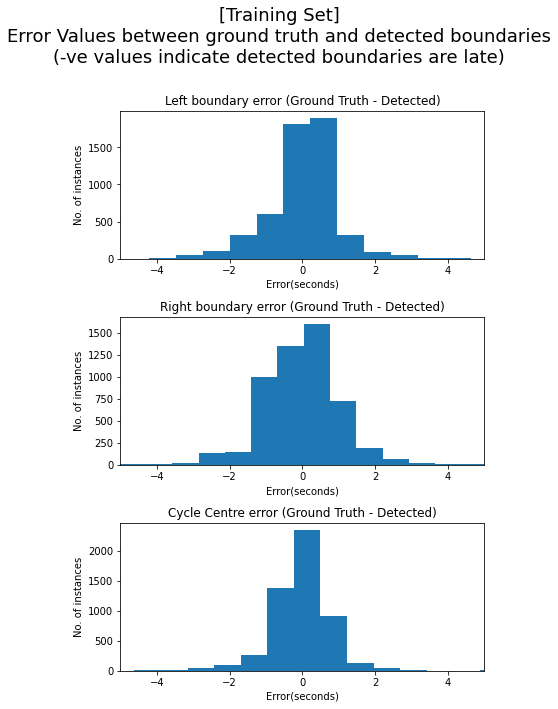

-Mean Errors-
Left Boundary:0.009259092130363314
Right Boundary:-0.02532107445122118
Centre:-0.008030991160428906


In [42]:
def plotBoundaryErrorSummary(overallCaption, leftBoundaryDiff, rightBoundaryDiff, centreDiffList):
    nBins = 50
    fig, axs = plt.subplots(3, figsize=(6,10))
    fig.suptitle(
        overallCaption + 
        '\nError Values between ground truth and detected boundaries\n(-ve values indicate detected boundaries are late)\n'
        , fontsize=18
    )
    
    axs[0].hist(leftBoundaryDiff, nBins)
    axs[0].set_title("Left boundary error (Ground Truth - Detected)")
    axs[0].set_xlim([-5, 5])
    
    axs[1].hist(rightBoundaryDiff, nBins)
    axs[1].set_title("Right boundary error (Ground Truth - Detected)")
    axs[1].set_xlim([-5, 5])
    
    axs[2].hist(centreDiffList, nBins)
    axs[2].set_title("Cycle Centre error (Ground Truth - Detected)")
    axs[2].set_xlim([-5, 5])
    
    for ax in axs.flat:
        ax.set(xlabel='Error(seconds)', ylabel='No. of instances')    
        
    plt.tight_layout() 
    plt.show()
    
    print("-Mean Errors-\nLeft Boundary:{0}\nRight Boundary:{1}\nCentre:{2}"
          .format(np.mean(leftBoundaryDiff), np.mean(rightBoundaryDiff),np.mean(centreDiffList)))
    
plotBoundaryErrorSummary("[Training Set]", *boundaryDiff)

In [43]:
from scipy.optimize import minimize

def boundaryErrorObj(leftRight):
    leftDiff, rightDiff, _ = calculateBoundaryError(trainFileNames, trainPeakData, leftRight)
    return np.abs(np.sum(leftDiff)) + np.abs(np.sum(rightDiff)) #i.e. make the means as close to 0 as possible

optimalPaddingRes = minimize(boundaryErrorObj, paddingTimeInit, method='BFGS',  options={'disp':True, 'maxiter':1})
optimalPadding = optimalPaddingRes.x
optimalPadding = paddingTimeInit #Value already optimized, commented lines above to save time.
print(optimalPadding)

         Current function value: 85.401560
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 4
(0.305, 1.391)


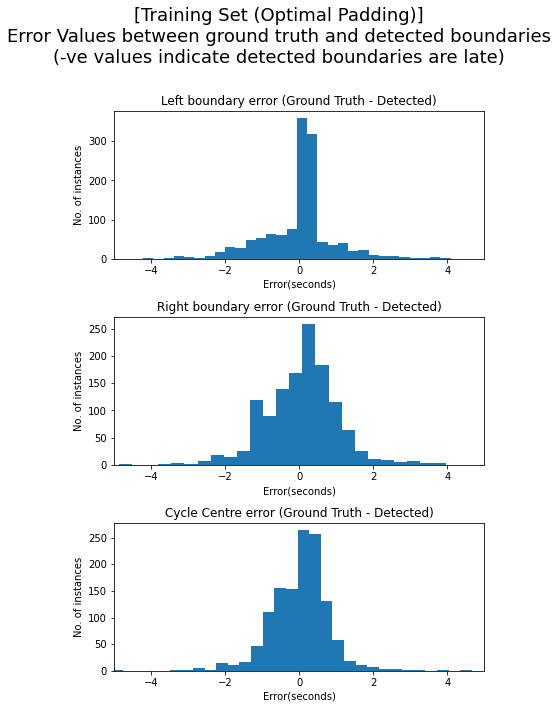

-Mean Errors-
Left Boundary:-0.04697018317882296
Right Boundary:0.03400931196247066
Centre:-0.00648043560817614


In [44]:
boundaryDiffOptimal = calculateBoundaryError(testFileNames, testPeakData, optimalPadding)
plotBoundaryErrorSummary("[Training Set (Optimal Padding)]", *boundaryDiffOptimal)

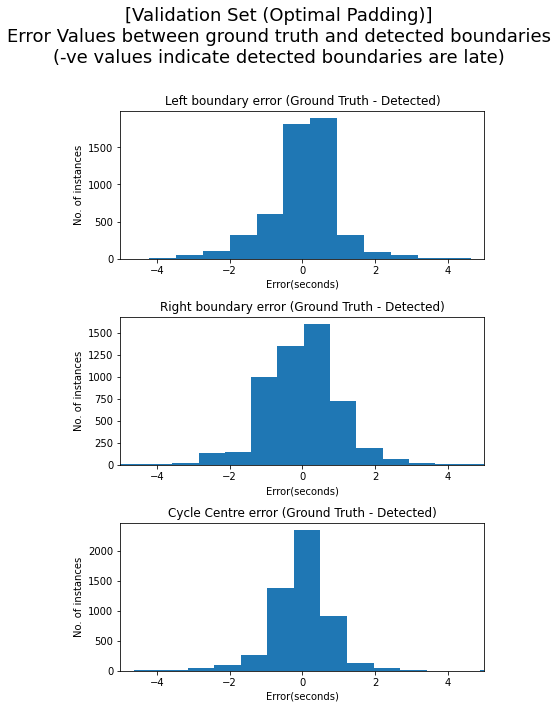

-Mean Errors-
Left Boundary:0.009259092130363314
Right Boundary:-0.02532107445122118
Centre:-0.008030991160428906


In [31]:
boundaryDiffOptimalValidation = calculateBoundaryError(trainFileNames, trainPeakData, optimalPadding)
plotBoundaryErrorSummary("[Validation Set (Optimal Padding)]", *boundaryDiffOptimalValidation)

No. of cycles from Hand Annotation:6898
No. of cycles from Peak Detection:10089
95th Percentile of Peak Detection Cycle Lengths:3.84s


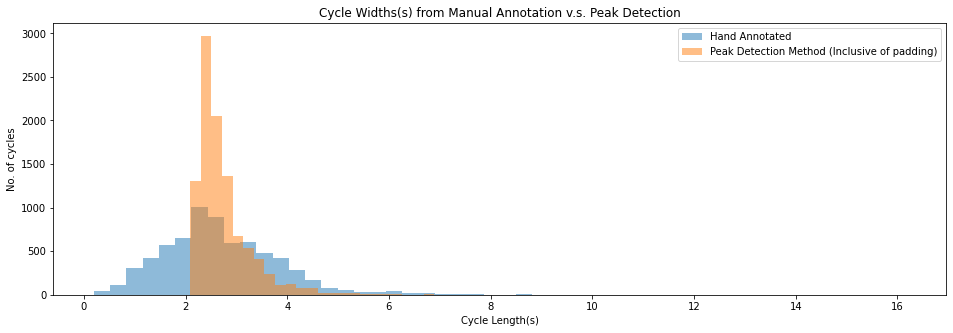

In [46]:
#Comparison between distribution of detected cycle times.
handAnnotatedWidths = []
for _, cycleInfoList in fileInfoDict.items():
    for cycleInfo in cycleInfoList:
        handAnnotatedWidths.append(cycleInfo[1] - cycleInfo[0])

peakDetectionWidths = []
for peaks in peakData:
    paddingOffset = sum(optimalPadding) #The times are before the left/right pads are added to the sample, re-add pad to get actual extracted length
    for leftRightBoundary in peaks[0][2]:
        peakDetectionWidths.append(leftRightBoundary[1] - leftRightBoundary[0] + paddingOffset)
        
print("No. of cycles from Hand Annotation:{0}".format(len(handAnnotatedWidths)))
print("No. of cycles from Peak Detection:{0}".format(len(peakDetectionWidths)))
print("95th Percentile of Peak Detection Cycle Lengths:{:.2f}s".format(np.percentile(peakDetectionWidths, 95)))

nBins = 50
plt.figure(figsize=(16,5))
plt.hist(handAnnotatedWidths, nBins, alpha=0.5, label='Hand Annotated')
plt.hist(peakDetectionWidths, nBins, alpha=0.5, label='Peak Detection Method (Inclusive of padding)')
plt.title("Cycle Widths(s) from Manual Annotation v.s. Peak Detection")
plt.ylabel("No. of cycles")
plt.xlabel("Cycle Length(s)")
plt.legend(loc='upper right')
plt.show()

In [47]:
def clamp(val, lowerInclusive, upperInclusive):
    if val > upperInclusive:
        return upperInclusive
    elif val < lowerInclusive:
        return lowerInclusive
    else:
        return val
    
#(timeSegments:(left_seconds:float, right_seconds:float), audioSamples:float[], sampleRate:int) => float[][]
def sliceAudio(timeSegments, audioSamples, sampleRate):
    maxSampleIdx = len(audioSamples) - 1
    segments = []
    for boundaries in timeSegments:
        left = clamp(int(boundaries[0] * sampleRate), 0, maxSampleIdx)
        right = clamp(int(boundaries[1] * sampleRate), 0, maxSampleIdx)
        segments.append(audioSamples[left:right])
    return segments

#(rawAudio:float[], 
# peakInfo:(smoothedSignal:float[], peakTiming:seconds[], peakLeftRightBoundaries:(left:float,right:float)[]), 
# padding:(left:float, right:float), 
# sampleRate:int)
#   => (audioClips:float[][], peakTimes:float[], leftRightBoundaries:(float,float)[])
def extractAudioWithPeakInfo(rawSignal, peakInfo, padding, sampleRate):
    maxSampleIdx = len(rawSignal) - 1
    maxTime = maxSampleIdx * sampleRate
    leftPadding, rightPadding = padding
    leftRightBoundaries = [(clamp(left - leftPadding, 0, maxTime), clamp(right + rightPadding, 0, maxTime)) for left, right in peakInfo[2]]
    audioSegments = sliceAudio(leftRightBoundaries, rawSignal, sampleRate)
    return (audioSegments, peakInfo[1], leftRightBoundaries)

#Get sample slices
#(audioClips:float[][], peakTimes:float[], leftRightBoundaries:(float,float)[])[]
extractedAudioClips = []
for signal, peakInfo in zip(noiseRemoved, peakData):
    extractedAudioClip = extractAudioWithPeakInfo(signal[0], peakInfo[0], optimalPadding, gSampleRate)
    extractedAudioClips.append((extractedAudioClip, signal[1]))
# extractedAudioClips = [extractAudioWithPeakInfo(signal, peakInfo, optimalPadding,gSampleRate) for signal, peakInfo in zip(noiseRemoved, peakData)]

In [61]:
extractedAudioClips[0][0][2]

[(0, 2.7755714285714284),
 (3.1847142857142856, 6.021),
 (4.807428571428572, 7.2051428571428575),
 (5.684571428571429, 7.863),
 (7.526571428571429, 10.494428571428571),
 (9.807142857142857, 12.161),
 (11.473714285714285, 14.090714285714286),
 (13.096428571428572, 15.274857142857142),
 (13.929714285714287, 16.283571428571427),
 (15.727857142857143, 18.607999999999997),
 (18.27157142857143, 20.493857142857145)]

In [68]:
audioFilePathsWithoutExtension

['200_2p4_Al_mc_AKGC417L',
 '185_1b1_Pr_sc_Litt3200',
 '184_1b1_Ar_sc_Meditron',
 '130_1p4_Pl_mc_AKGC417L',
 '145_2b2_Lr_mc_AKGC417L',
 '147_1b4_Tc_mc_AKGC417L',
 '221_2b2_Pl_mc_LittC2SE',
 '130_2b3_Ar_mc_AKGC417L',
 '223_1b1_Pl_sc_Meditron',
 '174_1p2_Ll_mc_AKGC417L',
 '133_2p4_Ar_mc_AKGC417L',
 '204_7p5_Al_mc_AKGC417L',
 '133_2p3_Al_mc_AKGC417L',
 '177_2b4_Al_mc_AKGC417L',
 '151_3p2_Tc_mc_AKGC417L',
 '158_1p4_Pr_mc_AKGC417L',
 '195_1b1_Pl_sc_Litt3200',
 '162_1b2_Pr_mc_AKGC417L',
 '197_1b1_Al_sc_Meditron',
 '210_1b1_Ar_sc_Meditron',
 '174_1p3_Pl_mc_AKGC417L',
 '107_2b3_Ar_mc_AKGC417L',
 '170_1b2_Lr_mc_AKGC417L',
 '151_2p2_Tc_mc_AKGC417L',
 '176_1b4_Al_mc_AKGC417L',
 '158_2p3_Lr_mc_AKGC417L',
 '162_2b2_Pr_mc_AKGC417L',
 '162_2b3_Al_mc_AKGC417L',
 '122_2b1_Ar_mc_LittC2SE',
 '107_3p2_Tc_mc_AKGC417L',
 '111_1b3_Tc_sc_Meditron',
 '158_1p3_Tc_mc_AKGC417L',
 '211_1p3_Ar_mc_AKGC417L',
 '154_3b3_Ar_mc_AKGC417L',
 '120_1b1_Ar_sc_Meditron',
 '172_1b3_Ar_mc_AKGC417L',
 '133_2p3_Tc_mc_AKGC417L',
 

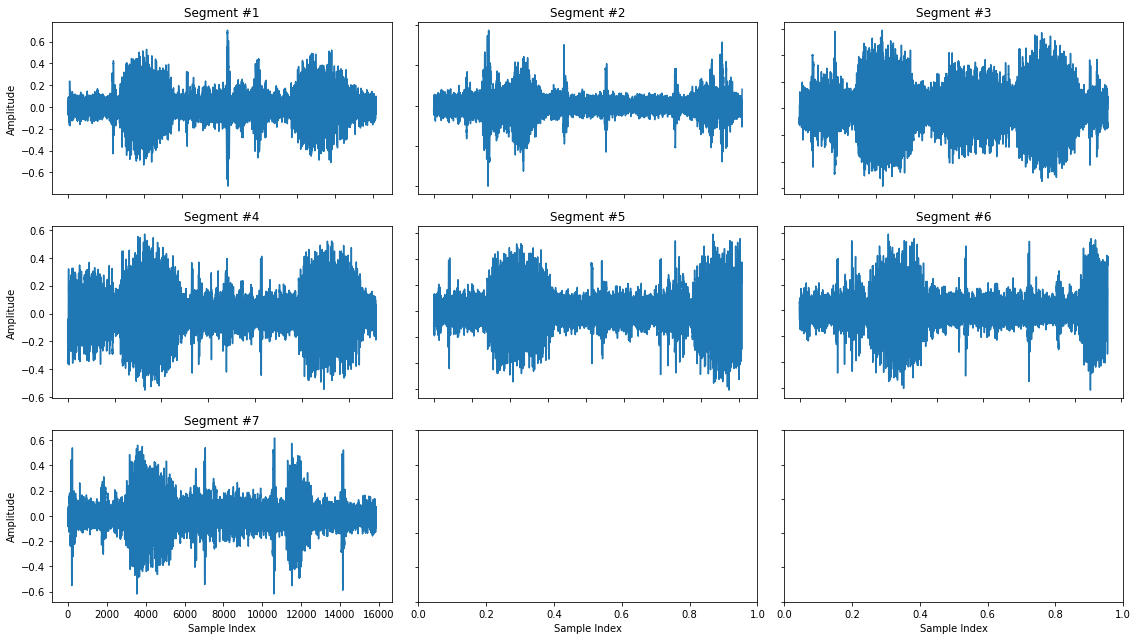

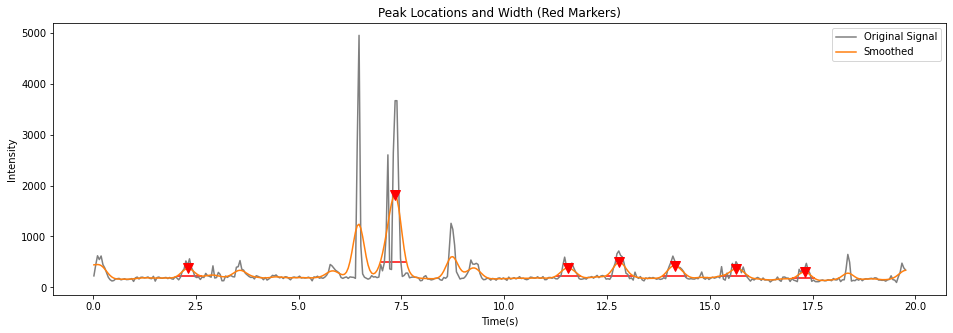

Original


Segment #1


Segment #2


Segment #3


Segment #4


Segment #5


Segment #6


Segment #7


In [42]:
def plotAllSamples(audioSegments):
    nPlots = len(audioSegments)
    cols = int(math.ceil(math.sqrt(nPlots)))
    rows = math.ceil(nPlots / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(16,9))
    for idx, sample in enumerate(audioSegments):
        row = idx // cols
        col = idx % cols
        ax = axs[row, col]
        ax.plot(sample)
        ax.set_title("Segment #{0}".format(idx + 1))
        
    for ax in axs.flat:
        ax.set(xlabel='Sample Index', ylabel='Amplitude')

    for ax in axs.flat:
        ax.label_outer()
        
    plt.tight_layout()   
    plt.show()
    
#plotAllSamples(onlyPeaks)
idx = 19
selectedClip = extractedAudioClips[idx][0]
plotAllSamples(selectedClip)
time, amp = getPowerEnvelop(spectrograms[idx], upperCutoffFreq, False)
_  = findPeaksAndWidthsFromSmoothedCurve(amp, time, windowSizeSeconds, plot=True)
print("Original")
ipd.display(ipd.Audio(audioBuffers[idx], rate=gSampleRate))
for i in range(len(selectedClip)):
    print("Segment #{0}".format(i + 1))
    ipd.display(ipd.Audio(selectedClip[i], rate=gSampleRate))

In [71]:
#(containingRegion:(left:float,right:float), targetRegion:(left:float,right:float)) => overlapFrac(0-1):float
def getOverlapFrac(containingRegion, targetRegion):
    overlap = max(0, min(containingRegion[1], targetRegion[1]) - max(containingRegion[0], targetRegion[0]))
    overlapFrac = overlap / (targetRegion[1] - targetRegion[0])
    return overlapFrac

def fracOfSampleCovered(groundTruth, autoDetectedWindow):
    overlap = max(0, min(groundTruth[1], autoDetectedWindow[1]) - max(groundTruth[0], autoDetectedWindow[0]))
    fracOfSampleCovered = overlap / (groundTruth[1] - groundTruth[0])
    return fracOfSampleCovered

#Applying labels to auto-extracted data
#(hand-annotated-labels:(start, end, hasCrackles, hasWheezes)[], auto-extracted-segments:(left,right)[], minOverlapFrac(0-1):float) => 
#transfered-labels:(left,right, hasCrackles, hasWheezes)[]
#Any segment where the overlap ratio with a hand annotated segment is more than <minOverlapFrac> will have the crackles/wheezes label applied
#minOverlapFrac is defined as the intersection between the hand-annotated segment and auto-detected segment, divided by the size of the auto-detected segment
def transferLabelToExtractedSegment(handAnnotation, automaticSegmentTimes, minOverlapFrac):
    transferredLabels = []
    handAnnotatedSegments = [(left, right) for left, right, _ , _ in handAnnotation]
    handAnnotatedLabels = [(hasCrackles, hasWheezes) for _, _, hasCrackles, hasWheezes in handAnnotation]
    for autoSegment in automaticSegmentTimes:
        overlapFractions = [getOverlapFrac(groundTruth, autoSegment) for groundTruth in handAnnotatedSegments]
        fracOfAnnSampleCovered = [fracOfSampleCovered(groundTruth, autoSegment) for groundTruth in handAnnotatedSegments]
        allSelectedLabels = [labels if (oFrac > minOverlapFrac or sFrac > minOverlapFrac) else (False, False) for oFrac, sFrac, labels in zip(overlapFractions,fracOfAnnSampleCovered, handAnnotatedLabels)]
        hasCrackles = any([bCrackles for bCrackles, _ in allSelectedLabels])
        hasWheezes = any([bWheezes for _, bWheezes in allSelectedLabels])
        transferredLabels.append((*autoSegment, hasCrackles, hasWheezes))
    return transferredLabels

#illustrative purposes
testIdx = 0
handAnnotations = fileInfoList[testIdx]
autoExtractedSegments = extractedAudioClips[testIdx][0][2]
print(handAnnotations)
#print(autoExtractedSegments)
print(transferLabelToExtractedSegment(handAnnotations, autoExtractedSegments, 0.5)) 

[(0.175, 3.297, False, False), (3.297, 7.805, False, False), (7.805, 11.594, False, False), (11.594, 15.902, False, False), (15.902, 17.387, False, False)]
[(0, 2.7755714285714284, False, False), (3.1847142857142856, 6.021, False, False), (4.807428571428572, 7.2051428571428575, False, False), (5.684571428571429, 7.863, False, False), (7.526571428571429, 10.494428571428571, False, False), (9.807142857142857, 12.161, False, False), (11.473714285714285, 14.090714285714286, False, False), (13.096428571428572, 15.274857142857142, False, False), (13.929714285714287, 16.283571428571427, False, False), (15.727857142857143, 18.607999999999997, False, False), (18.27157142857143, 20.493857142857145, False, False)]


In [74]:
#Apply annotation transfer to all cycles.

#(handAnnotationList:(start, end, hasCrackles, hasWheezes)[],
# autoSegmentList:(audioClips:float[][], peakTimes:float[], leftRightBoundaries:(float,float)[])[], 
# minOverlapFrac:float) =>
#    autoSegmentWithLabels(audioClips:float[][], peakTimes:float[], cycleInfo:(float,float, hasCrackles, hasWheezes)[])[]
def transferLabels(handAnnotationList, autoSegmentList, minOverlapFrac):
    autoSegmentWithTransferLabels = []
    for handAnn, autoSeg in zip(handAnnotationList,autoSegmentList):
        xferredLabels = transferLabelToExtractedSegment(handAnn, autoSeg[0][2], minOverlapFrac)
        autoSegmentWithTransferLabels.append((autoSeg[0][0], autoSeg[0][1], xferredLabels, autoSeg[1]))
    return autoSegmentWithTransferLabels
                                             
minOverlapFrac = 0.5
transferredLabels = transferLabels(fileInfoList, extractedAudioClips, minOverlapFrac)

In [96]:
transferredLabels[0][1]

array([ 0.332     ,  3.92828571,  5.50714286,  6.25271429,  8.22628571,
       10.50685714, 12.17342857, 13.62071429, 14.454     , 16.55914286,
       18.88357143])

In [103]:
transferredLabels[0][3]

'200'

In [93]:
patient_diag = pd.read_csv('./Respiratory_Sound_Database/patient_diagnosis.csv', names=['pid', 'disease'])
patient_diag.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [107]:
df = pd.DataFrame(columns=['start', 'end', 'crackles', 'weezles', 'pid', 'mode', 'filename'])
def getFilenameInfo(file):
    return file.split('_')

for file, fname in tqdm(zip(transferredLabels, audioFilePathsWithoutExtension)):
    name_data = getFilenameInfo(fname)
    for labels in file[2]:
        df.loc[len(df)]=[labels[0], labels[1], labels[2], labels[3], file[3], name_data[-2], fname]

920it [00:33, 27.15it/s]


In [108]:
df

,start,end,crackles,weezles,pid,mode,filename
0,0,2.775571,False,False,200,mc,200_2p4_Al_mc_AKGC417L
1,3.18471,6.021000,False,False,200,mc,200_2p4_Al_mc_AKGC417L
2,4.80743,7.205143,False,False,200,mc,200_2p4_Al_mc_AKGC417L
3,5.68457,7.863000,False,False,200,mc,200_2p4_Al_mc_AKGC417L
4,7.52657,10.494429,False,False,200,mc,200_2p4_Al_mc_AKGC417L
...,...,...,...,...,...,...,...
10084,4.71971,7.205143,False,True,124,sc,124_1b1_Al_sc_Litt3200
10085,6.03543,8.520857,False,True,124,sc,124_1b1_Al_sc_Litt3200
10086,7.30729,9.792714,False,True,124,sc,124_1b1_Al_sc_Litt3200
10087,8.57914,10.976857,False,True,124,sc,124_1b1_Al_sc_Litt3200


In [109]:
patient_diag.pid=patient_diag.pid.astype('int32')
df.pid=df.pid.astype('int32')
data=pd.merge(df,patient_diag,on='pid')
data.head()

,start,end,crackles,weezles,pid,mode,filename,disease
0,0,2.775571,False,False,200,mc,200_2p4_Al_mc_AKGC417L,COPD
1,3.18471,6.021000,False,False,200,mc,200_2p4_Al_mc_AKGC417L,COPD
2,4.80743,7.205143,False,False,200,mc,200_2p4_Al_mc_AKGC417L,COPD
3,5.68457,7.863000,False,False,200,mc,200_2p4_Al_mc_AKGC417L,COPD
4,7.52657,10.494429,False,False,200,mc,200_2p4_Al_mc_AKGC417L,COPD


In [111]:
data.to_csv('csv_data/data2.csv',index=False)

In [113]:
os.makedirs('processed_audio_files2')
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 start                            0
end                        2.77557
crackles                     False
weezles                      False
pid                            200
mode                            mc
filename    200_2p4_Al_mc_AKGC417L
disease                       COPD
Name: 0, dtype: object


In [114]:
def getPureSample(raw_data,start,end,sr=gSampleRate):
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    
    '''
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

In [115]:
import librosa as lb
import soundfile as sf
from tqdm import tqdm
i,c=0,0
for index,row in tqdm(data.iterrows()):
    maxLen=4
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen
    
    audio_file_loc=basePath + filename + '.wav'
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'
    
    save_path='processed_audio_files/' + filename
    c+=1
    
    audioArr,sampleRate=lb.load(audio_file_loc)
    pureSample=getPureSample(audioArr,start,end,sampleRate)
    
    #pad audio if pureSample len < max_len
    reqLen=6*sampleRate
    padded_data = lb.util.pad_center(pureSample, reqLen)
    
    sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
print('Total Files Processed: ',c)

0it [00:00, ?it/s]<ipython-input-115-1d8aa3718677>:33: FutureWarning: Pass size=132300 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  padded_data = lb.util.pad_center(pureSample, reqLen)
1it [00:00,  1.22it/s]<ipython-input-115-1d8aa3718677>:33: FutureWarning: Pass size=132300 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  padded_data = lb.util.pad_center(pureSample, reqLen)
2it [00:01,  1.21it/s]<ipython-input-115-1d8aa3718677>:33: FutureWarning: Pass size=132300 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  padded_data = lb.util.pad_center(pureSample, reqLen)
3it [00:02,  1.21it/s]<ipython-input-115-1d8aa3718677>:33: FutureWarning: Pass size=132300 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  padded_data = lb.util.pad_center(pureSample, reqLen)
4it [00:03,  1.20it/s]<ipython-i

KeyboardInterrupt: 